# 🤖 Robo Reviews

## Load all necessary packages

In [1]:
import sys, os
sys.path.append(os.path.abspath('../..'))  # adjust levels to reach project root
from utils.dataframe import load_and_clean_data
from models.classifiers.classifier_model import run_complete_pipeline
from models.clusters.product_analyzer import save_report, cluster_categories, get_top_products_by_category, save_text_file
from models.summarizers.summarization_gemini import generate_recommendation_article_from_clusters

## Load Data and Clean it up

In [2]:
# Load dataset from a function in the dataframe module
df = load_and_clean_data()
df.head()

Processing DataFrame from '1429_1.csv'...
Finished processing '1429_1.csv'. Found 34660 rows.
Processing DataFrame from 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'...
Finished processing 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'. Found 5000 rows.
Processing DataFrame from 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'...
Finished processing 'Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'. Found 28332 rows.

Merging all datasets...
Total rows after merge: 67992
Filled 1636 product names based on ID.
Remaining 5124 NA names will be dropped in the final cleanup.
Dropped 2153 duplicate reviews.
Dropped 5175 rows due to missing (MUST HAVE) data.
Final merged dataset has 60664 rows.


,id,product_name,categories,review_rating,review_text,review_title,image_urls,review_date,review_recommend,review_helpful_count,source_urls,review_username,review_username,data_source
0,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,This product so far has not disappointed. My c...,Kindle,NaN,2017-01-13T00:00:00.000Z,True,0.0,NaN,Adapter,Adapter,1429_1.csv
1,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,great for beginner or experienced person. Boug...,very fast,NaN,2017-01-13T00:00:00.000Z,True,0.0,NaN,truman,truman,1429_1.csv
2,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,Inexpensive tablet for him to use and learn on...,Beginner tablet for our 9 year old son.,NaN,2017-01-13T00:00:00.000Z,True,0.0,NaN,DaveZ,DaveZ,1429_1.csv
3,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",4.0,I've had my Fire HD 8 two weeks now and I love...,Good!!!,NaN,2017-01-13T00:00:00.000Z,True,0.0,NaN,Shacks,Shacks,1429_1.csv
4,AVqkIhwDv8e3D1O-lebb,"All-New Fire HD 8 Tablet, 8 HD Display, Wi-Fi,...","Electronics,iPad & Tablets,All Tablets,Fire Ta...",5.0,I bought this for my grand daughter when she c...,Fantastic Tablet for kids,NaN,2017-01-12T00:00:00.000Z,True,0.0,NaN,explore42,explore42,1429_1.csv


## Classifier Model


STARTING COMPLETE PIPELINE
PART 1: DATA PREPARATION

Dataset shape: (60664, 16)

Sentiment distribution:
sentiment
positive    55591
neutral      2698
negative     2375
Name: count, dtype: int64

Sentiment percentages:
sentiment
positive    91.637545
neutral      4.447448
negative     3.915007
Name: proportion, dtype: float64

CREATING STRATIFIED TRAIN-TEST SPLIT

Train set size: 48531
Test set size: 12133

Train set distribution:
sentiment
positive    44473
neutral      2158
negative     1900
Name: count, dtype: int64

Test set distribution:
sentiment
positive    11118
neutral       540
negative      475
Name: count, dtype: int64

PART 2: BASELINE MODEL - LOGISTIC REGRESSION

Vectorizing text with TF-IDF...
TF-IDF matrix shape: (48531, 5000)

Training Logistic Regression (with class balancing)...

--------------------------------------------------------------------------------
BASELINE MODEL EVALUATION
--------------------------------------------------------------------------------



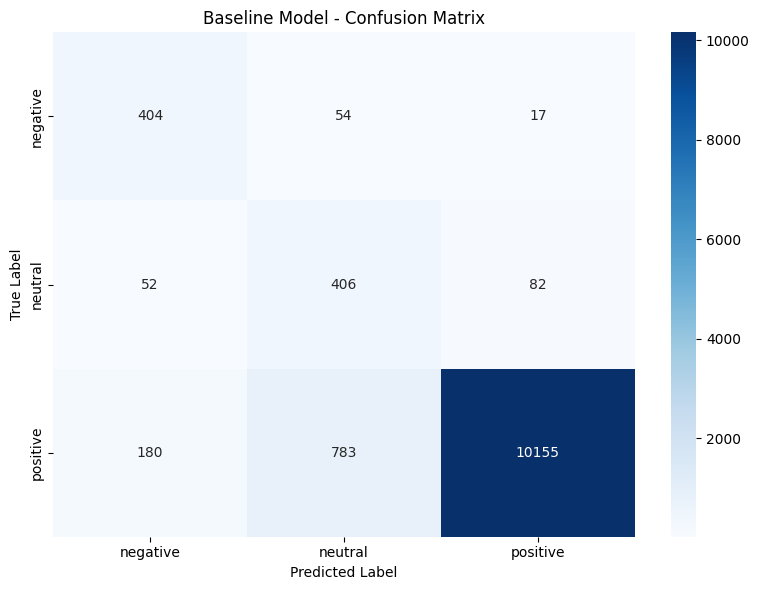


PART 4: PREDICTING ON FULL DATASET

Using Baseline Model for predictions...

Predictions complete!
Predicted sentiment distribution:
predicted_sentiment
positive    51207
neutral      6193
negative     3264
Name: count, dtype: int64

Saved full predictions to: ./results/sentiment_analysis_linear_regression.csv

PIPELINE COMPLETE!


In [3]:
df_classified = run_complete_pipeline(df, './results')

## Clustering

In [4]:
project_root = os.path.abspath(os.path.join(os.getcwd(), '.'))
results_dir = os.path.join(project_root, 'results')

print("\n[STEP 3/4] Executing product clustering...")
# 1. Cluster the data
df_clustered, cluster_metrics_str = cluster_categories(df_classified, n_clusters=4)

# Save the metrics string immediately
save_text_file(
    cluster_metrics_str, 
    output_dir=results_dir, 
    filename='clustering_metrics.txt'
)
# ------------------------------------------------------------------
# 🌟 NEW FILTERING LOGIC
# ------------------------------------------------------------------

# 2. Filter out products with 'Unknown Product' names (assuming they were NaNs previously)
original_rows = len(df_clustered)
df_clustered = df_clustered[
    df_clustered['product_name'] != 'Unknown Product'
].copy()

print(f"\nFiltered {original_rows - len(df_clustered)} rows with 'Unknown Product' name.")


# 3. Filter out known non-tech products based on keywords (e.g., Cat Litter, Dog Crate)
NON_TECH_KEYWORDS = ['litter', 'dog', 'cat', 'crate', 'wire', 'basics']

# Create a boolean mask: True if the product name does NOT contain any non-tech keyword
filter_condition = df_clustered['product_name'].str.lower().apply(
    lambda name: not any(keyword in name for keyword in NON_TECH_KEYWORDS)
)

rows_before_non_tech_filter = len(df_clustered)
df_clustered = df_clustered[filter_condition].copy()

print(f"Filtered {rows_before_non_tech_filter - len(df_clustered)} rows containing non-tech keywords.")
print(f"Remaining rows for analysis: {len(df_clustered)}")

if df_clustered.empty:
    print("Warning: DataFrame is empty after filtering. Cannot generate report.")

print("\n[STEP 4/4] Generating and saving final report...")
final_report = get_top_products_by_category(df_clustered, top_n=3)

save_report(final_report, output_dir=results_dir, filename='top_products_report.csv')

df_summarization = df_clustered[[
    'review_text', 'review_title', 'product_name', 
    'metacategory', 'predicted_sentiment', 'id'
]].copy()

save_report(df_summarization, output_dir=results_dir, filename='summarization_data_clustered.csv')

print("\n==================================================")
print("CLUSTERING NOTEBOOK COMPLETE.")
print(f"Files saved to: {results_dir}")
print("==================================================")


[STEP 3/4] Executing product clustering...

--- Starting Product Clustering with k=4 ---
Clustering based on 81 unique products (vs. 60664 reviews).
Using the column: categories
PROCESSED TEXT >>>>> [First 5 samples]
0    featured brands,e-readers & accessories,ebook ...
1    ebook readers,tablets,electronics,amazon eread...
2    amazon smp,tv, video & home audio,electronics,...
3    electronics features,fire tablets,computers & ...
4    walmart for business,office electronics,tablet...
Name: processed_text, dtype: object
Feature Matrix Shape: (81, 432)
Reducing dimensionality with PCA to 50 components...
Applying K-Means clustering...
Cluster Distribution:
cluster_id
0    25
1    29
2    17
3    10
Name: count, dtype: int64

--- Evaluating Cluster Quality Metrics ---
  - Silhouette Score: 0.1827
    (Interpretation: Close to +1 is great, 0 is overlapping, negative is bad)
  - Davies-Bouldin Index: 2.1795
    (Interpretation: Closer to 0 is better. Measures separation)
  - Calinski-Ha

## Summarization

In [5]:
final_article = generate_recommendation_article_from_clusters('./results')
print("Attempting to run article generation pipeline...")


STARTING ARTICLE GENERATION (FROM CLUSTERED DATA)
Loaded 49292 detailed reviews.

Calling Gemini API to generate the article (Model: gemini-2.5-flash)...

Final article saved successfully to: ./results/final_recommendation_article.txt
Attempting to run article generation pipeline...
